<a href="https://colab.research.google.com/github/cgpilapanta/timeseries/blob/main/TEG_Cap_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CAPÍTULO 04. ANÁLISE ESPECTRAL**
---
*   Autor: Christian G. Pilapanta A.
*   Data : Outubro de 2024
*   Lotação: Departamento de Geomática - UFPR / Laboratorio de Geodésia Espacial e Hidrografia

---

**Definição do entorno de trabalho e Importação de dados**

In [195]:
#Bibliotecas de Python necessárias para rodar o código
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pickle
import scipy.stats as st
import matplotlib as mpl
import scipy.fft

mpl.rc('font',size=16,weight='bold') #set default font size and weight for plots

In [196]:
# Importar (clonar) repósitorio de GitHub
!rm -r timeseries
!git clone https://github.com/cgpilapanta/timeseries.git

Cloning into 'timeseries'...
remote: Enumerating objects: 291, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 291 (delta 14), reused 0 (delta 0), pack-reused 254 (from 1)
Receiving objects: 100% (291/291), 36.44 MiB | 17.44 MiB/s, done.
Resolving deltas: 100% (115/115), done.


## **4.1. Introdução aos Harmônicos**

Em certas ocasiões, na análise de séries temporais, resultantes da observação de processos estocásticos, o oobjetivo básico é o de aproximar uma função do tempo por uma combinação linear de harmônicos (componentes senoidais), os coeficientes dos quais são as transformadas de Fourier discretas da série.

<center><img src=https://kls2177.github.io/Climate-and-Geophysical-Data-Analysis/_images/sine_cosine.png width="800"></center>

  <center>Figura 01. Funções seno (vermelha) e cosseno (azul)</center>

  <center>Fonte: Smith, K. (2024)</center>

### **4.1.1. Função Seno**

Uma função seno pode ser representada da forma:

$$ y\left ( t \right )=Asen\left ( 2\pi ft+\phi  \right ) =Asen\left ( \omega t+\phi  \right )$$

onde:

* $A$ é a amplitude (i.e. o desvio da curva de zero).
* $f$ é a frequência em unidades do número de oscilações que ocorrem a cada unidade de tempo.
* $\omega =2\pi f$ é a frequência angular, ou a frequência em unidades de radianos por unidade de tempo.
* $\phi $ é a fase (em radianos), ou o deslocamento.

neste ponto, também é importante lembrar que:

* $T$ é o periodo, definido como o número de unidades de tempo por oscilação (i.e. $\frac{1}{f}$).
* $k$ é o número de onda ou "wavenumber", o número inteio de oscilações que cabem dentro do domínio $k=fT$.

### **4.1.2. Séries de Fourier**

Uma série de Fourier é uma forma de representação de uma série temporal através da somatória de funções harmônicas, cada uma delas com uma escala temporal única.

De forma análoga à regressão, onde tenta-se descrever uma varíavel através da combinação de outras, no caso da análise harmônica, as funções a serem ajustadas (ou seja, os preditores) são senos e cossenos do tipo:

$$sen\left ( 2\pi k\frac{1}{T} \right )$$

e

$$cos\left ( 2\pi k\frac{1}{T} \right )$$

onde $k$ é um inteiro entre 1 e $ \frac{N}{2}$ frequentemente chamado de "wavenumber").

Usando esta estrutura, podemos escrever uma série temporal $y\left ( t \right )$ como:

$$y\left ( t \right )=A_{0}+\sum_{k=1}^{\frac{N}{2}}A_{k}cos\left ( 2\pi k\frac{1}{T} \right )+\sum_{k=1}^{\frac{N}{2}}B_{k}sen\left ( 2\pi k\frac{1}{T} \right )$$

onde:

* $y$ é resolvido no intervalo de tempo $0\leq t\leq T$.
* o comprimento da série temporal é $N+ 1$ (note-se que $N$ precisa ser par para que o maior número de onda seja um inteiro).
* $A_{k}$ e $B_{k}$ são os coeficientes da regressão para cada preditor (i.e. cada preditor é uma função harmônica com frequência $2\pi \frac{k}{T}$ portanto, se encaixa no intervalo de $t_{1}=0$ a $t_{N+1}=T$ um número inteiro de vezes).

Importante:

* se $k=1$, a função tem frequência $2\pi$
radianos no comprimento total dos dados. Esta é a menor frequência resolvida.
* se $k=\frac{N}{2}$, a função tem frequência $2\pi$
radianos em 2 unidades de tempo (e $B_{k}$ é zero). Este é o maior número de onda/frequência que pode ser resolvido usando a série de Fourier, chamada de frequência de Nyquist.

Para um maior análise disto, assistir o video: [Fourier Series Animation using Circles](https://www.youtube.com/watch?v=LznjC4Lo7lE&feature=emb_logo).

#### Exemplo 01. Série de Fourier
---

1. Definição de parámetros das funções (Periodo $T$ e Taxa de amostragem $ΔT$

In [197]:
# harmonic parameters (period and sampling rate)
T = 4.0
sampling_rate = 0.05

# define time dimension based on period and sampling rate
t = np.arange(0.,T+sampling_rate,sampling_rate)

# length of time series
N = len(t)-1

**Importante:**

Note-se que o periodo $T$ dividido por $N$ é igual à taxa de amostragem $\Delta t$.

2. Plotagem das funções

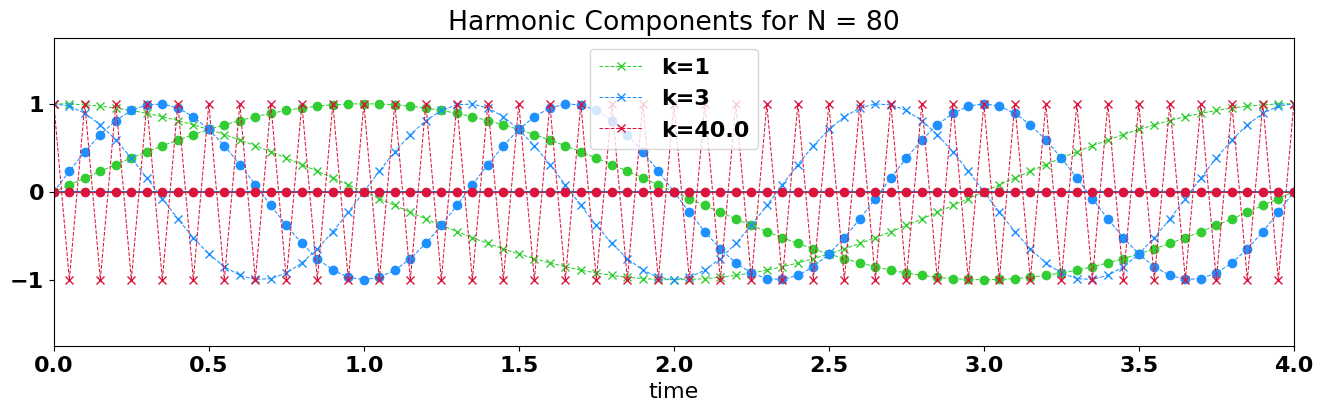

In [198]:
# colours for plotting
CLRs = ['limegreen','dodgerblue','crimson']

# initialize figure
plt.figure(figsize=(16,4))
plt.xlim(np.min(t),np.max(t))
plt.ylim(-1.75,1.75)
plt.xlabel('time')
plt.title('Harmonic Components for N = ' + str(N))
plt.axhline(0)

# counting index for changing the plotting colour
count = 0

# loop over three values for wavenumber, k
for k in (1,3,N/2):

    # define sine and cosine components of y(t)
    y1 = np.cos(2.*np.pi*k*t/T)
    y2 = np.sin(2.*np.pi*k*t/T)

    # plot harmonic components
    plt.plot(t,y1,'x--',color = CLRs[count],linewidth = 0.75, label = 'k='+str(k))
    plt.plot(t,y2,'o--',color = CLRs[count],linewidth = 0.75)

    count += 1

plt.legend()

plt.show()

**Importante:**

O que acontece quando $k=\frac{N}{2}$ (frequência Nyquist)? O componente da função senoidal se torna zero para todo tempo $t$.

### **4.1.3. Número de onda/Frequência Nyquist**

O número de onda/frequência Nyquist ($k=\frac{N}{2}$) é a maior frequência que pode ser resolvida em seus dados usando uma série de Fourier.

* Mas porque não pode ser $k=N$?

 Se $k=\frac{N}{2}$, a função tem frequência de $2\pi$
radianos a cada 2 unidades de tempo. Se $k=N$, implicaria que a função tem uma frequência de 2
radianos a cada 1 unidade de tempo.

* Podemos detectar um ciclo completo em uma única unidade de tempo?

 Não podemos. Em outras palavras, não podemos resolver frequências maiores que a frequência de Nyquist.

#### Exemplo 02. Frequência de Nyquist
---

1. Definição de parámetros das funções (Periodo $T$ e Taxa de amostragem $ΔT$

In [199]:
# harmonic parameters (period and sampling rate)
T = 10.
sampling_rate = 0.01

# define time dimension based on period and sampling rate
t = np.arange(0.,T+sampling_rate,sampling_rate)

# length of time series
N = len(t)-1

print("The wavenumber corresponding to the Nyquist frequency is",N/2) # Nyquist wavenumber: k = N/2
print("This means that the Nyquist frequency is", N/2/T,"\n") # using f = k/T

The wavenumber corresponding to the Nyquist frequency is 500.0
This means that the Nyquist frequency is 50.0 



**Na sequência:**

Examinamos como a taxa de amostragem afeta as frequências resolvidas. Assumimos que temos uma onda cosseno “verdadeira” e uma que estamos tentando resolver usando uma taxa de amostragem de frequência mais baixa.

Em algum ponto, a taxa de amostragem não é suficiente para resolver a frequência/número de onda da onda cosseno, demonstrando que a frequência de Nyquist é o limite.

2. Definição da nova dimensão de tempo (frequência baixa)

In [200]:
# low frequency t used to demonstrate how sampling rate effects our ability to detect all frequencies
sampling_rate_low = 1.0

# define time dimension based on period and sampling rate
tl = np.arange(np.min(t),np.max(t)+sampling_rate_low,sampling_rate_low)

print("The wavenumber corresponding to the Nyquist frequecy for the low-frequency sampling rate is",(len(tl)-1)/2)
print("This means that the Nyquist frequency for the low-frequency sampling rate is", (len(tl)-1)/2/T,"\n")

The wavenumber corresponding to the Nyquist frequecy for the low-frequency sampling rate is 5.0
This means that the Nyquist frequency for the low-frequency sampling rate is 0.5 



**Importante:**

Observe como o número de onda/frequência de Nyquist muda. Isso significa que só seremos capazes de detectar a frequência correta da onda cosseno até número de onda = 5,0 ou frequência = 0,5 para a taxa de amostragem dada.

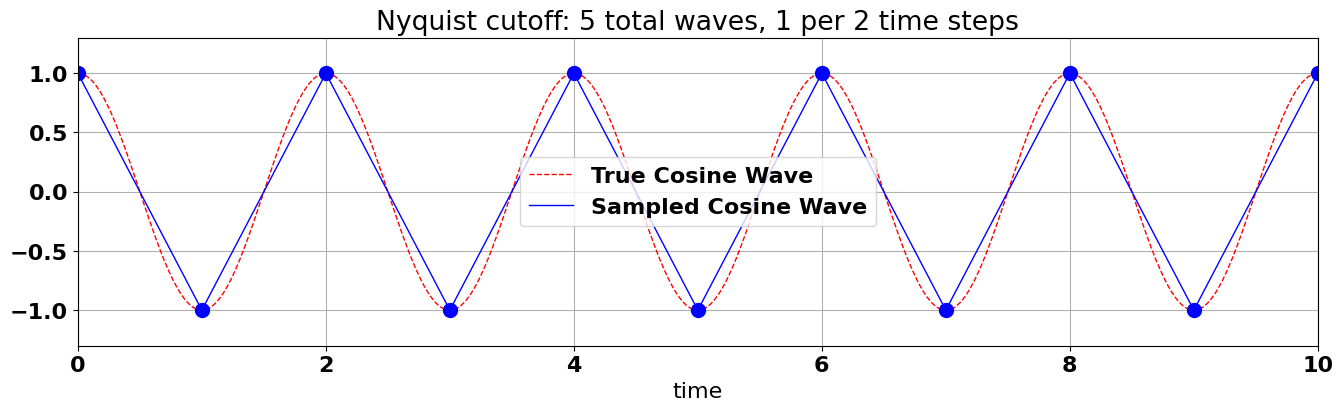

In [201]:
k = 5 # see what happends when you change wavenumber to the following values (1, 3, 5, 7, 10)

# initialize figure
plt.figure(figsize=(16,4))
plt.xlim(np.min(t),np.max(t))
plt.ylim(-1.3,1.3)
plt.xlabel('time')
plt.title('Nyquist cutoff: 5 total waves, 1 per 2 time steps')
plt.grid()

# define cosine wave using high-frequency t: this will be our "true" cosine wave
yh = np.cos(2.*np.pi*k*t/T)

# plot true cosine wave
plt.plot(t,yh,'--',color = 'red', linewidth = 1.,label='True Cosine Wave')

#define harmonics using low-frequency t
yl = np.cos(2.*np.pi*k*tl/T)

plt.plot(tl,yl,'.',color = 'blue',markersize = 20)
plt.plot(tl,yl,'-',color = 'blue', linewidth = 1.,label='Sampled Cosine Wave')
plt.legend()
plt.show()

**Importante:**

O que acontece quando $k$ se torna maior que o número de onda Nyquist $k=5$? Em outras palavras, o que acontece se tivermos frequências mais altas em nossos dados?

Nesse caso, elas serão aliasadas para frequências mais baixas (por exemplo, quando $k=7$ no exemplo acima).

Isso pode ser um problema quando há uma grande quantidade de variação em frequências maiores que a frequência de Nyquist.

Observe que a frequência de Nyquist depende completamente da sua taxa de amostragem (resolução temporal dos seus dados), **NÃO** da quantidade total de dados que você tem. Quanto menor a unidade de tempo, maior a frequência Nyquist.

### Exemplo 03. Filtragem de um sinal sazonal usando harmônicos no domínio temporal. Camadas de gelo do Artico (SIE GCM)
---

##### Definição da função ccgfilt (Fonte: [NOAA Global Monitoring Laboratory](https://gml.noaa.gov/ccgg/mbl/crvfit/crvfit.html))

In [202]:
# Código da função ccgfilt3

"""
Class for computing the curve fitting/smoothing technique used by Thoning et al
1989.

This technique uses the following step:

   1 - Fit a function consisting of a polynomial and harmonics to the data
   2 - Smooth the residuals from the function fit with a low-pass filter using
       fft and user defined cutoff value.
   3 - Calculate the inverse fft of the low-pass filter to get smoothed data in
       time domain.
   4 - Determine the smoothed curve of interest by combining the function with
       the filtered data.

The function to be fit to the data is specified in the routines 'fitFunc' and
'harmonics'.
"""

import sys
import datetime

from math import pi, sqrt, atan2
from scipy import optimize
from scipy import stats
from scipy import interpolate
from scipy import fftpack
import numpy
numpy.seterr(over='ignore')


# --------------------------------------------------
# Define the function we are trying to fit
# This is a combination of a polynomial and harmonic function
# --------------------------------------------------
def fitFunc(params, x, numpoly, numharm):
    """ Calculate the function at time x with coefficients given in params.
    This is a combination of a polynomial with numpoly coefficients, and
    a sin/cosine harmonic with numharm coefficients.
    e.g., with numpoly=3 and numharm=2:

        y = a + b*x + c*x^2 + d*sin(2*pi*x) + e*cos(2*pi*x) + f*sin(2*pi*x*2) + g*cos(2*pu*x*2)

    where a = params[0], b = params[1], c = params[2], d = params[3] ...
    """

    # polynomial part
    # we need to reverse the order of the polynomial coefficients for input into polyval
    p = numpy.polyval(params[numpoly-1::-1], x)

    # get harmonic part of function
    s = harmonics(params, x, numpoly, numharm)

    return p+s

# --------------------------------------------------


def harmonics(params, x, numpoly, numharm):

    """ calculate the harmonic part of the function at time x """

    # harmonic part
    pi2 = 2*pi*x
    if numharm > 0:
        # create an array s of correct size by explicitly evaluating first harmonic
        s = params[numpoly]*numpy.sin(pi2) + params[numpoly+1]*numpy.cos(pi2)

        # do additional harmonics (nharm > 1)
        for i in range(1, numharm):
            ix = 2*i + numpoly    # index into params for harmonic coefficients
            s += params[ix]*numpy.sin((i+1)*pi2) + params[ix+1]*numpy.cos((i+1)*pi2)

        n = numpoly + 2*numharm
        s = (1+params[n]*x) * s        # amplitude gain factor

        return s
    else:
        return 0

# --------------------------------------------------
# function to calc the difference between input values and function


def errfunc(p, x, y, numpoly, numharm):
    return y - fitFunc(p, x, numpoly, numharm)

# --------------------------------------------------


class ccgFilter:
    """
    Input Parameters
    ----------
    xp : numpy array
    time values for input data
    yp : numpy array
    dependent values for input data
    shortterm : int
    Short term cutoff value in days for smoothing of data
        Optional. Default is 80
    longterm : int
    Long term cutoff value in days for extracting trend from data
        Optional. Default is 667
    sampleinterval : int
    Interval in days between samples, calculate equally spaced values at this interval
        Optional. Default is calculated from xp
    numpoly : int
    Number of polynomial terms used in function fit - e.g. 3 = quadratic
        Optional.  Default is 3
    numharm : int
    Number of harmonics used in function fit
        Optional.  Default is 4
    timezero : float
    Value where x = 0 in the function coefficients
        Optional.  Default is 0
    gap : float
    When determining equally spaced values for the fft,
    if gap != 0, then gap is the number of days between samples that should
    be filled in with values from the function, rather than linear interpolated.
        Optional.  Default is 0
    debug: boolean
    If true, print out extra information during calculations.
        Optional.  Default is false


    Attributes
    ----------
      Input Data
    xp : numpy array
        Time value for input data
    yp : numpy array
        Dependent values for input data
    np : int
        Number of points in xp, yp
    xinterp : numpy array
        Equally spaced interpolated values from input data

      For the function fit
    numpoly : int
        Number of polynomial terms used in function fit - e.g. 3 = quadratic
    numharm : int
        Number of harmonics used in function fit
    timezero : float
        Value where x = 0 in the function coefficients
    params : numpy array
        Parameters (coefficients) for the function fit
    covar : numpy array
        Covariance values of the parameters
    numpm : int
        Total number of parameters in the function
    resid : numpy array
        Residuals from function fit for times specified in input array xp
    yinterp : numpy array
        Equally spaced interpolated values of the residuals from the functions fit
            for times specified in array xinterp

      For the filter
    sampleinterval : int
        Interval in days between equally spaced points used in the fft
    dinterval : float
        Sample interval in decimal years
    shortterm : int
        Short term cutoff value in days for smoothing of data
    longterm : int
        Long term cutoff value in days for extracting trend from data
    smooth : numpy array
        smoothed results from applying short term cutoff filter to residuals of data from the function.
            Equally spaced at xinterp
    trend : numpy array
        trend results from applying long term cutoff filter to residuals of data from the function.
        Equally spaced at xinterp
    deriv : numpy array
        derivative of function + trend.  Equally spaced at xinterp
    ninterp : int
        number of points in each of xinterp, smooth, trend

      Misc.
    rsd1 : float
            Standard deviation of residuals about function
    rsd2 : float
            Standard deviation of residuals about smooth curve
    debug : boolean
        Flag for showing additional information during computation

    Methods
    -------
      For each of the methods below, the input value x can be a single point, a list, or a numpy array

      getFunctionValue(x)
    Returns the value of the function part of the filter at time x.

      getSmoothValue(x)
    Returns the 'smoothed' data at time x.  This is function + self.smooth

      getTrendValue(x)
    Returns the 'trend' of the data at time x.  This is polynomial part of function + self.trend

      getHarmonicValue(x)
    Returns the value of the harmonic part of the function at time x.

      getPolyValue(x)
    Returns the value of the polynomial part of the function at time x

      getAmplitudes()
    Get seasonal cycle amplitudes
    Returns a list of tuples, each tuple has 6 values (year, total_amplitude, max_date, max_value, min_date, min_value)


      Additional methods:

        getFilterResponse(cutoff)
          Returns the value of the filter for frequencies 0 - 10 cycles/year at given cutoff

        getMonthlyMeans()
          Return of list of tuples containing monthy means from the smoothed curve.
      The value of the curve is computed at every sample interval, then summed up for each
          month and the average computed.

        getTrendCrossingDates()
      Get the dates when the smoothed curve crosses the trend curve.
      That is, when the detrended smooth seasonal cycle crosses 0.

    """

    def __init__(self, xp, yp, shortterm=80, longterm=667, sampleinterval=0, numpolyterms=3, numharmonics=4, timezero=-1, gap=0, debug=False):
        t0 = datetime.datetime.now()
        # save input data as numpy arrays
        self.xp = numpy.array(xp)
        self.yp = numpy.array(yp)
        self.np = len(xp)
        # Calculate the average time interval between data points.
        # Set the sampleinterval variable if not set on the command line.
        if sampleinterval == 0:
            # calculate the average interval between samples that are at least 1 day apart
            sd = 0
            sdiff = 0
            tx = self.xp[0]
            for i in range(1, self.np):
                if self.xp[i]-tx > 0.002739:
                    diff = self.xp[i]-tx
                    sdiff += diff
                    sd += 1
                tx = self.xp[i]

            avginterval = sdiff/sd * 365

            if avginterval > 1:
                self.sampleinterval = round(avginterval, 0)
            else:
                self.sampleinterval = avginterval
            if debug:
                print("changed sampleinterval to {}".format(self.sampleinterval))

        else:
            self.sampleinterval = sampleinterval

        self.dinterval = self.sampleinterval/365.0  # sample interval in decimal years

        # If the data is actually an average over a relatively large time period,
        # such as annual averages, change the number of harmonics to an appropriate value.
        nh = int(365.0/(self.sampleinterval*2))
        if nh < numharmonics:
            self.numharm = nh
            if debug:
                print("changed numharmonics to {}".format(nh))
        else:
            self.numharm = numharmonics

        self.shortterm = shortterm
        self.longterm = longterm
        self.numpoly = numpolyterms
        if timezero < 0:
            self.timezero = int(xp[0])
            if debug:
                print("changed timezero to {}".format(self.timezero))
        else:
            self.timezero = timezero
        self.debug = debug
        self.numpm = self.numpoly + 2*self.numharm

        # apply filter to data
        self._filter_data(gap)

        # compute derivatives of polynomial and long term trend
        self._compute_deriv()

        # standard deviation of residuals about smooth curve
        r = self.yp - self.getSmoothValue(self.xp)
        # rmean = numpy.mean(r)
        self.rsd2 = numpy.std(r, ddof=1)
        if self.debug:
            print("rsd about smooth curve is {}".format(self.rsd2))

        t1 = datetime.datetime.now()
        if self.debug:
            print("Total time elapsed: {}".format(t1-t0))

    # ------------------------------------------------------------

    def _filter_data(self, gap):

        if self.debug:
            print("=== Inside filter_data. ===")
            print("  Number of points = {a}, Sample Interval = {b} days, {c} years".format(a=self.np, b=self.sampleinterval, c=self.dinterval))
            print("  Cutoff 1 = {}, Cutoff 2 = {}".format(self.shortterm, self.longterm))
            print("  Numpoly = {}, Numharm = {}".format(self.numpoly,self.numharm))
            print("  First point = {},{}".format(self.xp[0], self.yp[0]))
            print("  Last point = {},{}".format(self.xp[-1], self.yp[-1]))

        # Remove the timezero value from the x data so that coefficients will be relative to the timezero date
        work = self.xp - self.timezero

        # Fit the function to the data
        pm = [1] * self.numpm        # initial parameter values set to 1
        pm.append(0)
        self.numpm += 1
        self.params, self.covar, info, mesg, ier = optimize.leastsq(errfunc, pm, full_output=1, args=(work, self.yp, self.numpoly, self.numharm))
        if self.debug:
            print("  Finished leastsq")
            for i in range(self.numpm):
                print("    param[{}] = {}".format(i, self.params[i]))

        #  calculate residuals from fit
        resid = self.yp - fitFunc(self.params, work, self.numpoly, self.numharm)
        rmean = numpy.mean(resid)
        self.rsd1 = numpy.std(resid, ddof=1)
        if self.debug:
            print("  Finished residuals")
            print("    rmean = {}, rsd = {}".format(rmean, self.rsd1))

        # fit linear line to ends of residual data
        # subtract this from residuals so ends are ~ near 0
        ca, cb = self._adjustend(work, resid, self.longterm)
        resid -= (ca + cb*work)
        if self.debug:
            print("  Finished adjustend")
            print("    ca = {}, cb = {}".format(ca, cb))
            print("    x[0] = {}, x[{}] = {}".format(work[0], self.np, work[-1]))
            print("    resid[0] = {}, resid[{}] = {}".format(resid[0], self.np, resid[-1]))

        # Interpolate data at evenly spaced intervals (self.sampleinterval)
        self.xinterp, yinterp = self._lin_interp(work, resid, gap)
        self.ninterp = len(self.xinterp)

        # add linear fit and timezero back in to residuals from function
        self.resid = resid + ca + cb*work
        if self.debug:
            print("  Interpolated points.")
            print("    Number of interpolated points: {}".format(self.ninterp))
            print("    xinterp[np-1] = {}, x[0] = {}".format(self.xinterp[-1], self.xinterp[0]))
            print("    yinterp[np-1] = {}, y[0] = {}".format(yinterp[-1], yinterp[0]))

        # do fft on interpolated data
        fft = fftpack.rfft(yinterp)

        # do short term filter
        if self.debug:
            print("  Do short term filter, cutoff = {}".format(self.shortterm))
        a = self._freq_filter(fft, self.dinterval, self.shortterm)
        yfilt = fftpack.irfft(a)
        self.smooth = yfilt + ca + cb*self.xinterp

        # do long term filter
        if self.debug:
            print("  Do long term filter, cutoff = {}".format(self.longterm))
        a = self._freq_filter(fft, self.dinterval, self.longterm)
        yfilt = fftpack.irfft(a)
        self.trend = yfilt + ca + cb*self.xinterp

        # add linear fit and timezero back in to interpolated values
        self.yinterp = yinterp + ca + cb*self.xinterp
        self.xinterp = self.xinterp + self.timezero


    # ------------------------------------------------------------
    def _adjustend(self, x, y, cutoff):
        """ Determine the slope of the data based on just the ends, i.e. 1/4 of the cutoff """

        # check if length of data is too short to adjust
        if x[-1] - x[0] < cutoff/365.0:
            return 0, 0

        # length of data to use is 1/4 of cutoff length
        c = cutoff/365.0/4.0

        z = numpy.where((x <= x[0] + c) | (x >= x[-1] - c))

        slope, intercept, r_value, p_value, std_err = stats.linregress(x[z], y[z])
        return intercept, slope

    #------------------------------------------------------------
    def _lin_interp(self, x, y, gap):
        """ Linear interpolate between input data to get equally spaced values
        at every sample interval.
        """

        # calculate the x values for evenly spaced data at the specified sampling interval
        xi = numpy.arange(x[0], x[-1]+self.dinterval/2, self.dinterval)
        xi[-1] = x[-1]        # make sure last point is equal to last data point

        # if there are multiple y data points at a single x value, then average them
        # to get only 1 y data point for each x
        xx = []
        yy = []
        xt = x[0]
        ys = y[0]
        ns = 1
        for xp, yp in zip(x[1:], y[1:]):
            if xp == xt:
                ys += yp
                ns += 1
            else:
                ya = ys/ns
                xx.append(xt)
                yy.append(ya)
                ys = yp
                ns = 1
            xt = xp
        ya = ys/ns
        xx.append(xt)
        yy.append(ya)

        # calculate interpolation values at each x point
        f = interpolate.interp1d(xx, yy)

        # if a gap setting was not made, use normal linear interpolation
        # to get equally space points.
        # Otherwise, fill in gaps using the function value (0) instead.
        if gap == 0:
            yi = f(xi)

        else:
            n = len(xx)
            ni = len(xi)
            yi = numpy.zeros((ni))
            j = 0
            for i in range(ni):
                while xi[i] >= xx[j]:
                    j += 1
                    if j >= n-1:
                        break

                j -= 1
                if (xx[j+1] - xx[j]) > gap/365.0: # 8*self.dinterval:
                    yi[i] = 0
                else:
                    yi[i] = f(xi[i])


        return xi, yi

    #------------------------------------------------------------
    def _freq_filter(self, fft, dinterv, cutoff):
        """ Apply low-pass filter to fft data.
        Multiply each discrete frequency in fft by a
        low-pass filter function value set by the value 'cutoff'
        input:
            fft - results of fft
            dinterv - sampling interval in years
            cutoff - cutoff value in days
        """

        n2 = len(fft)
        cf = cutoff/365.0    # convert cutoff to years
        cutoff2 = 1.0/cf    # change to cycles/year

        freq = fftpack.rfftfreq(n2, dinterv)    # get array of frequencies
        rw = self._vfilt(freq, cutoff2, 6)    # get filter value at frequencies
        filt = fft*rw                # apply filter values to fft


        return filt

# this is how to do filtering at each frequency
#    filt = numpy.zeros( (len(fft)) )
#    b = 1.0/(n2*dinterv)
#    for i in range(1, n2-1, 2):
#        freq = (i+1)/2.0 * b
#        rw = self._fnfilt(freq, cutoff2, 6)
#        filt[i] = fft[i]*rw
#        filt[i+1] = fft[i+1]*rw
#
#    dmaxfreq = 1.0/(2*dinterv)
#    rw = self._fnfilt(dmaxfreq, cutoff2, 6)
#    filt[-1] = fft[-1]*rw
#    filt[0] = fft[0]
#    def _fnfilt(self, freq, sigma, power):
#    """ Determine filter value at freq """
#
#    z = pow((freq/sigma), power)
#    if z > 20.0:
#        f = 1e-10
#    else:
#        f = 1.0 / pow(2.0, z)
#
#    return f
#
#    return filt

    #------------------------------------------------------------
    def _vfilt(self, freq, sigma, power):
        """ vectorized version of getting filter value at a frequency
        input:
            freq - array of frequencies
            sigma - cutoff value in cycles/year
            power - integer value for f/fc^power
        returns:
            array of filter values at each frequency

        the clip statement insures against underflow, although
        numpy seems to handle it internally anyway
        """
        z = numpy.power((freq/sigma), power)
#        z = numpy.clip(z, 0, 20.0)
        f = 1.0 / numpy.power(2.0, z)
        return f


    #------------------------------------------------------------
    def _compute_deriv(self):
        """ Compute derivative of trend.
        This is the derivative of self.trend + derivative of polynomial part of the function
        """

        # Connect trend data points with spline to get derivative at each point
        tck = interpolate.splrep(self.xinterp, self.trend, s=0.0)
        self.deriv = interpolate.splev(self.xinterp, tck, der=1)

        # compute derivative of polynomial at each interpolated data point
        # we need to reverse order of polynomial coefficients for input into poly1d
        poly = numpy.poly1d(self.params[self.numpoly-1::-1])
        pd = numpy.polyder(poly)
        self.deriv += pd(self.xinterp - self.timezero)

    #------------------------------------------------------------
    def stats(self):

        stats = ""
        if self.np == 0:
                stats += "No data points.  No Statistics available."
                return;

        # GetCalendarDate(self.timezero, &year, &month, &day, &hour, &minute, &second);

        stats += "*****  Filter Statistics.  *****\n"

        stats += "Beginning date:                 %.6f\n" % self.xp[0]
        stats += "Ending date:                    %.6f\n" % self.xp[self.np-1]

        stats += "Number of data points:          %d\n\n" % self.np

        stats += "FUNCTION PARAMETERS\n"
#        stats += "Time = 0 on %d/%d/%d\n"        ,  year, month, day
        stats += "Time = 0 on %f\n" % self.timezero  # year, month, day
        stats += "Number of polynomial terms:     %d\n" % self.numpoly
        stats += "Number of harmonic terms:       %d\n" % self.numharm
        stats += "Total Number of parameters:     %d\n" % self.numpm
        stats += "------------------------------------------------------\n"
        stats += "Parameter          Value          Standard Deviation\n"
        stats += " Polynomial\n"
        for i in range(self.numpm):
            if i == self.numpoly: stats += " Harmonics\n"
            if i == self.numpoly + 2*self.numharm:
                stats += " Amplitude Gain Factor\n"
                stats += "%5d %20.6f %20.6f\n" % (i, self.params[i], sqrt(self.covar[i][i]))

            stats += "------------------------------------------------------\n"
            stats += "Harmonic   Amplitude  Std. Dev.    Phase (degrees)  Std. Dev.\n"
        for i in range(1, self.numharm+1):
            ix = 2*(i-1)+self.numpoly
            a = self.params[ix]
            b = self.params[ix+1]
            c = a*a+b*b
            siga = (a*a*self.covar[ix][ix]+b*b*self.covar[ix+1][ix+1])/c
            sigtheta = (b*b*self.covar[ix][ix]+a*a*self.covar[ix+1][ix+1])/(c*c)
            stats += "%5d %11.2f %10.2f %16.2f %12.2f\n" % (i, sqrt(c), sqrt(siga), atan2(b,a)*180/pi, sqrt(sigtheta)*180.0/pi)

        stats += "------------------------------------------------------\n"
        stats += "Full covariance matrix:\n"
        for i in range(self.numpm):
            for j in range(self.numpm):
                    stats += "%13.4e" % self.covar[i][j]
                    stats += "\n"

        stats += "------------------------------------------------------\n"
#      stats += "Chi squared value of function fit: %f\n",chisq)
        stats += "Residual standard deviation about function: %f\n" % self.rsd1
        stats += "------------------------------------------------------\n"
        stats += "\n"
        stats += "FILTER PARAMETERS\n"
        stats += "Short term self cutoff:       %3d days\n" % self.shortterm
        stats += "Long term self cutoff:        %3d days\n" % self.longterm
        stats += "Sampling interval:            %3g days\n" % self.sampleinterval
        stats += "\n"
#        stats += "Function Standard Deviation:          %8.4f" % sqrt(self.funcvar)
#        stats += "Short Term Filter Standard Deviation: %8.4f" % sqrt(self.varf1)
#        stats += "Long  Term Filter Standard Deviation: %8.4f" % sqrt(self.varf2)
#        stats += "Smoothed curve Standard Deviation:    %8.4f" % sqrt(self.varf1 + self.funcvar)
#        stats += "Trend curve Standard Deviation:       %8.4f" % sqrt(self.varf2 + self.funcvar)
#        stats += "Detrended Cycle Standard Deviation:   %8.4f" % sqrt(self.varf2 + self.varf1 + 2*self.funcvar)
#        stats += "Growth Rate Standard Deviation:       %8.4f" % sqrt(2*(self.varf2 + self.funcvar))
        stats += "\n"

        stats += "Residual standard deviation about smooth curve: %f\n" % self.rsd2

        return stats

    #------------------------------------------------------------
    def getAmplitudes(self):
        """ Get amplitudes of seasonal cycle for each year.
        The amplitude is from the detrended data, which is the
        harmonic part of function + smooth curve - trend curve.
        Find max and min values of this for each year, save the values
        and the dates at which they occur.

        Returns
        --------
        A list of tuples, each tuple has 6 values (year, total_amplitude, max_date, max_value, min_date, min_value)
        """

        # get harmonic part of function at interpolated data points
        ycycle = harmonics(self.params, self.xinterp-self.timezero, self.numpoly, self.numharm)

        # added short term smoothed data
        ycycle = ycycle + self.smooth - self.trend

        # Find max and min values of the seasonal cycle
        tyear = int(self.xinterp[0])
        amps = []
        amax = -9999
        amin = 9999
        for x,y in zip(self.xinterp, ycycle):
            year = int(x)
            if year != tyear:
                t = (tyear, amax - amin, dmax, amax, dmin, amin)
                amps.append(t)
                amax = -9999
                amin = 9999
                dmax = 0
                dmin = 0
                tyear = year
            if y > amax:
                amax = y
                dmax = x
            if y < amin:
                amin = y
                dmin = x

        return amps

    #------------------------------------------------------------
    def getFunctionValue(self, x):
        """ Determine the value of the function at time x.
        x can be either a single point or a list
        """

        return fitFunc(self.params, x-self.timezero, self.numpoly, self.numharm)

    #------------------------------------------------------------
    def getSmoothValue(self, x):
        """ Return the 'smoothed' data at time x
        This is the function plus the smoothed residuals.
        """

        ysmooth = self.getFunctionValue(self.xinterp)
        ysmooth = ysmooth + self.smooth

        f = interpolate.interp1d(self.xinterp, ysmooth, bounds_error=False)
        yi = f(x)

        return yi

    #------------------------------------------------------------
    def getTrendValue(self, x):
        """ Return the 'trend' of the data at time x
        This is the polynomial part of the function plus the trend of the residuals.
        i.e., poly plus the long term filter of the residuals
        """

        ytrend = self.getPolyValue(self.xinterp)
        ytrend = ytrend + self.trend

        f = interpolate.interp1d(self.xinterp, ytrend)
        yi = f(x)

        return yi

    #------------------------------------------------------------
    def getPolyValue(self, x):
        """ Get the values of the polynomial part of the function time x

        Returns
        -------
        A numpy 1d array with the polynomial values at the given x
        """

        xa = numpy.array(x)

        p = numpy.polyval(self.params[self.numpoly-1::-1], xa-self.timezero)

        return p

    #------------------------------------------------------------
    def getHarmonicValue(self, x):
        """ Get the values of the harmonic part of the function time x

        Returns
        -------
        A numpy 1d array with the harmonic values at the given x
        """

        xa = numpy.array(x)

        # get harmonic part of function at x
        y = harmonics(self.params, xa-self.timezero, self.numpoly, self.numharm)

        return y

    #------------------------------------------------------------
    def getGrowthRateValue(self, x):
        """ Get the values of the derivative of the trend

        Returns
        -------
        A numpy 1d array with the growth rate values at the given x
        """

        f = interpolate.interp1d(self.xinterp, self.deriv)
        yi = f(x)

        return yi

    #------------------------------------------------------------
    def getFilterResponse(self, cutoff):
        """ Get the filter response for a range of frequencies.
        Input
        -----
        cutoff - cutoff value in days for the filter

        Returns
        -------
        Two 1d numpy arrays, length 1000, with the frequency and the corresponding filter response
        for the given cutoff.

        Range of frequencies is 0 to 2*cutoff frequency, in 1000 steps
        """

        fmax = (365.0/float(cutoff)) * 2
        fstep = fmax/1000.
        cf = cutoff/365.0
        cutoff2 = 1.0/cf
        freq = numpy.linspace(0, fmax, 1000)
        rw = self._vfilt(freq, cutoff2, 6)    # get filter value at frequencies

        return freq, rw

    #------------------------------------------------------------
    def getMonthlyMeans(self):
        """ Get monthly mean values from the smoothed curve
        Note: first and last months could be incomplete

        Returns
        --------
        A list of tuples, each tuple has 5 values (year, month, value, std. deviation, n)
        """

        ysmooth = self.getSmoothValue(self.xinterp)

        a = []
        data = []
        tyear = 0
        tmonth = 0
        for x, y in zip(self.xinterp, ysmooth):
            (year, month, day, hour, minute, second) = self.calendarDate(x)

            if year != tyear or month != tmonth:
                if len(a):
                    mean = numpy.mean(a)
                    std = numpy.std(a, ddof=1)
                    data.append((tyear, tmonth, mean, std, len(a)))
                    a = []

            a.append(y)
            tyear = year
            tmonth = month

        mean = numpy.mean(a)
        std = numpy.std(a, ddof=1)
        data.append((year, month, mean, std, len(a)))

        return data

    #------------------------------------------------------------
    def getTrendCrossingDates(self):
        """ Get the dates when the smoothed curve crosses the trend curve.
        That is, when the detrended smooth seasonal cycle crosses 0.
        """

        # get harmonic part of function at interpolated data points
        ycycle = harmonics(self.params, self.xinterp-self.timezero, self.numpoly, self.numharm)

        # added short term smoothed data
        ycycle = ycycle + self.smooth - self.trend

        tcup = []
        tcdown = []
        tyear = int(self.xinterp[0])
        ty = ycycle[0]
        for x,y in zip(self.xinterp, ycycle):

            if ty < 0.0 and y >= 0.0:
                tcup.append(x)
            if ty > 0.0 and y <= 0.0:
                tcdown.append(x)

            ty = y


        return (tcup, tcdown)



    ###################################################
    # Don't use these routines for resolution less than 1 second.
    def calendarDate(self, decyear):

        dyr =  int(decyear)
        fyr = decyear - dyr

        if dyr % 4 == 0:
            nsec = fyr * (366*86400)
        else:
            nsec  = fyr * (365*86400)

        nsec = round(nsec, 0)

        ndays = int(nsec / 86400)
        doy  = ndays + 1

        if doy > 366:
            dyr = dyr + 1
            doy = 1
        month, day = self.to_mmdd(dyr, doy)

        nsecs = round(nsec - (ndays*86400), 0)
        hour  = int(nsecs / 3600)
        minute = int((nsecs - (hour *3600)) / 60)
        seconds = int(round(nsecs - (hour * 3600.0) - (minute * 60.0), 0))

        return dyr,month,day,hour,minute,seconds


    ###################################################
    def to_mmdd(self, year, doy):

        if year % 4 == 0:
            mona = [31,29,31,30,31,30,31,31,30,31,30,31]
        else:
            mona  = [31,28,31,30,31,30,31,31,30,31,30,31]

        idoy =  doy
        imon = 0
        while idoy - mona[imon] > 0:
            idoy  = idoy - mona[imon]
            imon += 1

        month = imon + 1
        return int(month), int(idoy)

##### Análise dos dados

1. Importar os dados

In [203]:
# read in data
fname = '/content/timeseries/datasets/smith/SIE_Total.pickle'
with open(fname,'rb') as fp:
    sie,lat,lon = pickle.load(fp, encoding = 'iso8859')

# convert sie to time series
# (I'm using np.ravel but you can also use np.reshape)
sie_ts = np.ravel(sie)

2. Cálculo da dimensão temporal em anos decimais

In [204]:
# convert time to "decimal year"
time = np.arange(1,len(sie_ts)+1)
dtime = time/365.0

3. Ajuste da função a um modelo padrão de 5 harmônicos

In [205]:
# create ccgfilt instance
filt = ccgFilter(dtime,sie_ts/1e12, sampleinterval=0, numpolyterms=0, numharmonics=5, timezero=-1, gap=0, debug=False)

4. Extração da componente harmônica

In [206]:
# extract the harmonic component of the fit, i.e. the seasonal cycle
sie_season = filt.getHarmonicValue(dtime)

5. Plotagem do harmônico principal

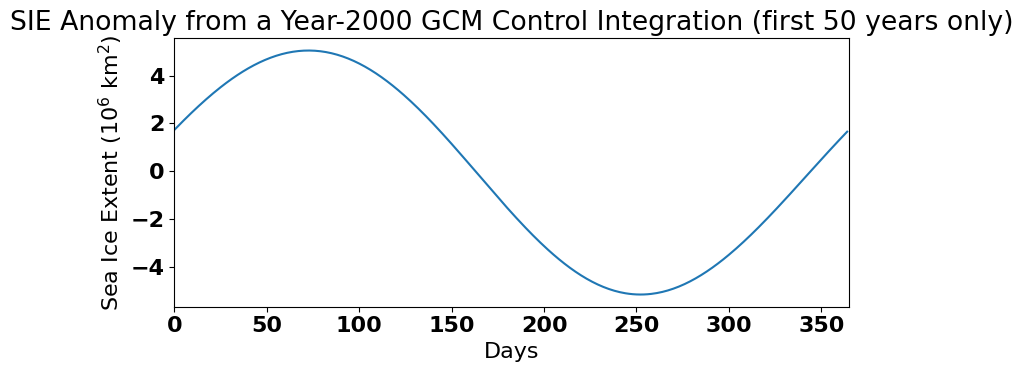

In [207]:
# plot seasonal cycle
plt.figure(figsize=(8,4))
plt.plot(sie_season[0:1*365]) # plot one year of harmonic time series to show seasonal cycle
plt.xlim(0,1*365)
plt.xlabel('Days')
plt.ylabel('Sea Ice Extent (10$^6$ km$^2$)')
plt.title('SIE Anomaly from a Year-2000 GCM Control Integration (first 50 years only)')
plt.tight_layout()

6. Filtragem do hârmonico da série de dados

In [208]:
# remove the seasonal cycle from original time series
sie_deseason5 = sie_ts/1e12 - sie_season

7. Plotagem da série filtrada

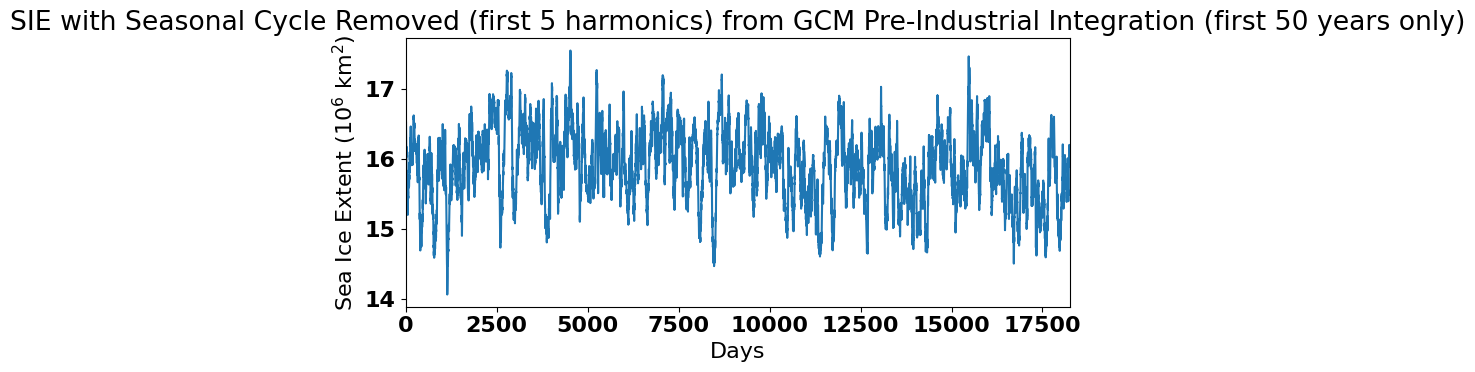

In [209]:
# plot to show that the seasonal cycle has been removed
plt.figure(figsize=(8,4))
plt.plot(sie_deseason5[0:50*365]) #this data consists of 400 years of daily data, but here I am just plotting 50 years
plt.xlim(0,50*365)
plt.xlabel('Days')
plt.ylabel('Sea Ice Extent (10$^6$ km$^2$)')
plt.title('SIE with Seasonal Cycle Removed (first 5 harmonics) from GCM Pre-Industrial Integration (first 50 years only)')
plt.tight_layout()

**Importante:**

Note-se que os harmônicos são ajustados à série temporal com a média de longo prazo removida (este é o parâmetro numpolyterms = 0). Assim, quando subtraímos o ciclo sazonal, obtemos uma anomalia que flutua em torno da média de longo prazo.

## **4.2. Domínio de Frequências**

Nas seções anteriores, aprendemos vários métodos de filtragem e suavização de dados no domínio do tempo. Uma maneira muito mais poderosa de filtrar dados é no domínio da frequência.

Para trabalhar no domínio da frequência, construiremos o conceito de série de Fourier e introduziremos a Transformada de Fourier.

A Transformada de Fourier nos permite determinar as escalas de tempo de variabilidade de uma série temporal decompondo a série temporal em seus componentes harmônicos. Vamos explorar como isso é feito usando o conceito de regressão, ou seja, pensando em uma série de Fourier como uma série temporal ajustada onde os preditores são os senos e cossenos.

Assim como a regressão linear, estamos trabalhando em direção a uma expressão da fração de variância explicada pelos ajustes com os diferentes componentes harmônicos.

**Problema**

Seja $y(t)$ uma série de tempo que consiste de um conjunto $n$ de dados discretos uniformemente espaçados.Considerando o dominio $0\leq t\leq T$, onde $0$ e $T$ coincidem com os dados $1$ e $N+1$, e $N$ é um número par.

Lembre-se de que podemos escrever $y(t)$
da forma:

$$y\left ( t \right )=A_{0}+\sum_{k=1}^{\frac{N}{2}}A_{k}cos\left ( 2\pi k\frac{1}{T} \right )+\sum_{k=1}^{\frac{N}{2}}B_{k}sen\left ( 2\pi k\frac{1}{T} \right )$$

Neste caso, o problema se resolve, obtendo os valores do intercepto $A_0$ e os coeficientes da regressão $A_k$ e $B_k$.

**Importante:**

* A média de cada função seno/cosseno no intervalo de
$t_1 = 0$ a $t_N + 1 = T$ é igual a 0, então, $A_0 = \bar{y}$.
* As funções harmônicas (i.e. preditores) são mutuamente ortogonais no intervalo (i.e. a correlação $\rho $ entre as funções seno e cosseno é zero e a correlação entre as funções seno ou cosseno com diferentes números de onda inteiros também é zero):

  $$\rho \left ( sen\left ( x \right ),cos\left ( x \right ) \right )=0$$

  $$\rho \left ( cos\left ( x \right ),cos\left ( 2x \right ) \right )=0$$

* Os coeficientes da regressão $y\left ( t \right )$ podem ser escritos como:

  $$A_{k},B_{k}=\frac{\bar{x'_{k}y'}}{\bar{x_{k}^{'2}}}$$

  onde:

  $$x_{k}=cos\left ( 2\pi k\frac{t}{T} \right )$$

  for $A_{k}$, e:

  $$x_{k}=sen\left ( 2\pi k\frac{t}{T} \right )$$

  for $B_{k}$.

* Todas as funções harmônicas têm variância $x_{k}^{'2}=\frac{1}{2}$, exceto para $k=\frac{N}{2}$, onde a variância do termo cosseno é $1$ e a variância do termo seno é $0$.

Do exposto acima, as soluções para cada preditor, $A_{k}$ e $B_{k}$ reduzem-se a:

$$A_{k}=\bar{2cos\left ( 2\pi k\frac{t}{T} \right )y'}$$

$$B_{k}=\bar{2sen\left ( 2\pi k\frac{t}{T} \right )y'}$$

$$A_{\frac{N}{2}}=\bar{cos\left ( 2\pi k\frac{t}{T} \right )y'}$$

$$B_{\frac{N}{2}}=0$$

onde o 2 na frente dos coeficientes vem do fato de que $x_{k}^{'2}=\frac{1}{2}$.

Assim, $y\left ( t \right )$ pode ser escrita  da forma:

$$y\left ( t \right )=\bar{y}+\sum_{k=1}^{\frac{N}{2}-1}\left ( A_{k}cos\left ( 2\pi k\frac{1}{T} \right )+B_{k}sen\left ( 2\pi k\frac{1}{T} \right ) \right )+A_{\frac{N}{2}}cos\left ( 2\pi k\frac{t}{T} \right )$$

Ou em sua forma simplificada, usando a amplitude de fase:

$$y\left ( t \right )=\bar{y}+\sum_{k=1}^{\frac{N}{2}}C_{k}cos\left ( 2\pi k\frac{t}{T}-\phi _{k} \right )$$

onde:

$$C_{k}^{2}=A_{k}^{2}+B_{k}^{2}$$

##### Exemplo 04. Decomposição usando Fourier. Fenomeno de "El Niño"
---

1. Importar dados

In [210]:
#set default font size and weight for plots
mpl.rc('font',size=16,weight='bold')

# load data
filename = '/content/timeseries/datasets/smith/NINO34_monthly_Jan1958_Dec2019.csv'
ENSO = np.squeeze(np.genfromtxt(filename, delimiter = ','))

# let's also reshape ENSO into one long time series
Ny,Nm = ENSO.shape
ENSO = np.reshape(ENSO,Ny*Nm)

2. Plotar dados

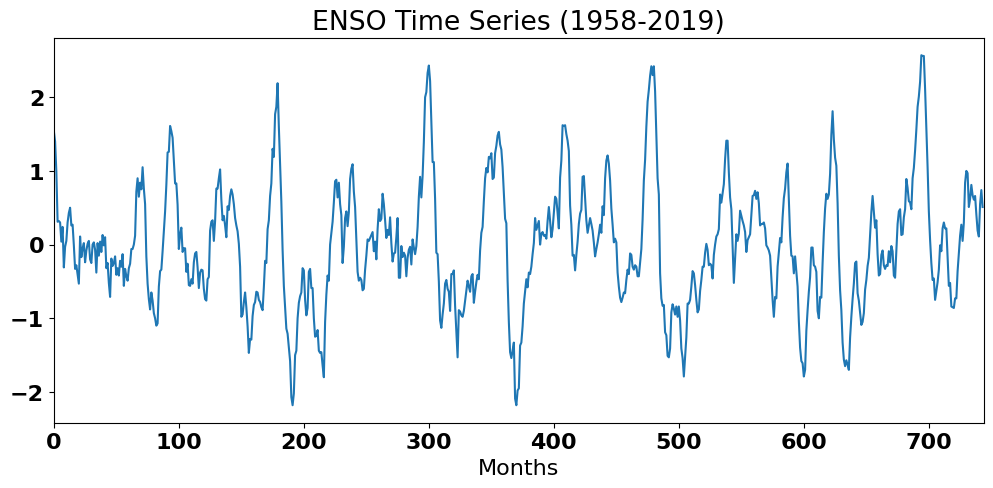

In [211]:
# plot ENSO time series
plt.figure(figsize=(12,5))
plt.plot(ENSO)
plt.title('ENSO Time Series (1958-2019)')
plt.xlabel('Months')
plt.xlim(0,len(ENSO))
plt.show()

3. Construção do harmônico base (5 anos)

In [212]:
# let's start with some parameters
# we are using monthly data, so the 5-year frequency and wavenumber are:

yr = 5.166666667 # note that we are using not exactly 5 years, such that k is an integer

# frequency
f = 1/float(12*yr)

# period
T = float(len(ENSO))

# wavenumber
k = f*T
print("The wavenumber is",k)

# time variable
time = np.arange(0,len(ENSO))

# argument for sine and cosine functions
theta = 2*np.pi*time*f

The wavenumber is 11.999999999225807


4. Construção das funções harmônicas

In [213]:
# do fourier decomposition (calculate sines and cosines for a given frequency)
coskd = np.cos(theta)
sinkd = np.sin(theta)

#  Calculate the coefficients for the harmonics
ak = 2*np.mean(coskd * ENSO)
bk = 2*np.mean(sinkd * ENSO)

# convert to amplitude and phase format
ck = np.sqrt(ak**2 + bk**2)
lk = np.arctan2(bk,ak)/k

# construct the 5-year frequency component of the ENSO time series
ENSO_5yr = ck*np.cos(theta - lk)

5. Plotagem da componente harmônica (5 anos)

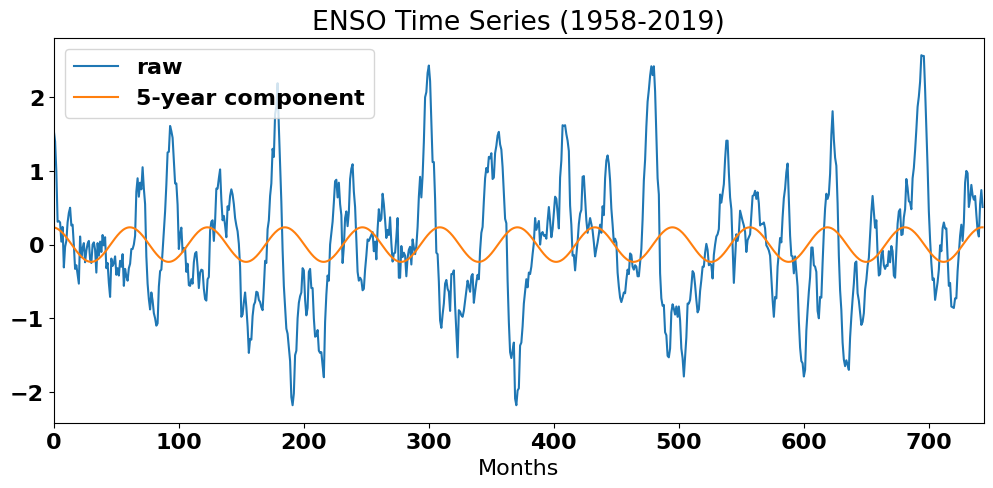

In [214]:
# plot original ENSO time series and 5-year component
plt.figure(figsize=(12,5))
plt.plot(ENSO,label='raw')
plt.plot(ENSO_5yr, label='5-year component')
plt.title('ENSO Time Series (1958-2019)')
plt.xlabel('Months')
plt.xlim(0,len(ENSO))
plt.legend()
plt.show()

## **4.3. Variância das funções harmônicas. Transformada discreta de Fourier (DFT)**

Se examinarmos de forma detalhada os componentes harmônicos de $y_{t}$, podemos expressar a fração de variância para cada componente harmônico da mesma forma que para uma regressão linear qualquer.

Especificamente, a fração de variância para um número de onda $k$ é:

$$R_{k}^{2}=\frac{\left ( \overline{x'_{k}y'} \right )^{2}}{\overline{x_{k}^{'2}}\overline{y^{'2}}}$$

Isto é muito semelhante ao coeficiente de determinação para uma regressão linear, mas agora podemos escrever um
$R$-quadrado para cada número de onda $k$.

Note-se que grande parte desta expressão se parece com as expressões para $A_{k}$ e $B_{k}$, pelo qual, podemos reescrever a equação de $R_{k}^{2}$ como:

$$R_{k}^{2}=\frac{A_{k}^{2}}{2\overline{y^{'2}}}$$

para as funções cosseno.

$$R_{k}^{2}=\frac{B_{k}^{2}}{2\overline{y^{'2}}}$$

para as funções seno, e:

$$R_{k}^{2}=\frac{A_{\frac{N}{2}}^{2}}{\overline{y^{'2}}}$$

no caso específico de $k=\frac{N}{2}$.

Isso é basicamente o que precisamos para determinar quanto da variância em $y_{t}$ vem dos diferentes componentes harmônicos. Assim, a fração de variância explicada por cada par harmônico (seno + cosseno) é:

$$R_{k}^{2}=\frac{A_{k}^{2}+B_{k}^{2}}{\overline{2y^{'2}}}=\frac{C_{k}^{2}}{\overline{2y^{'2}}}$$

Podemos aproximar a variância de $y_{t}$ como:

$$\sum_{k=1}^{\frac{N}{2}}\frac{C_{k}^{2}}{2}$$

tal que:

$$R_{k}^{2}=\frac{C_{k}^{2}}{\sum_{k=1}^{\frac{N}{2}}C_{k}^{2}}$$

Esta última equação é chamada de Transformada Discreta de Fourier.

Um gráfico de $\frac{C_{k}^{2}}{\sum_{k=1}^{\frac{N}{2}}C_{k}^{2}}$ frente a $k$ ou $f$ chama-se de espectro de potência discreta de $y_{t}$, onde usamos as palavras potência e variância de forma intercambiável.

Como exemplo, a próximafigura mostra as DFT de uma função senoidal e de uma função quadrática.

<center><img src=https://kls2177.github.io/Climate-and-Geophysical-Data-Analysis/_images/DFTs.png width="800"></center>

<center>Figura 02.DFT de uma função senoidal ($k=4$) e uma função quadrática</center>

<center>Fonte: Smith, K. (2024)</center>

#### Exemplo 05. Decomposição usando DFT. Fenomeno de "El Niño"
---

1. Definição dos parâmetros iniciais (fração da variância para diferentes números de onde no intervalo $k=1$ e $k=\frac{N}{2}$

In [215]:
# compute variance as a function of k
time = np.arange(0,len(ENSO))
k_all = np.arange(1,len(ENSO)/2+1)

ck2 = []

for i in k_all:
    T = float(len(ENSO))
    k = i
    theta = 2*np.pi*time*k/T

    coskd = np.cos(theta)
    sinkd = np.sin(theta)

    ak = ENSO*coskd
    bk = ENSO*sinkd

    ak_mean = np.mean(ak)*2
    bk_mean = np.mean(bk)*2

    #Use the Pythagorean Theorem to convert to amplitude and phase format
    ck2.append((ak_mean**2 + bk_mean**2)/2)

ck2 = np.asarray(ck2)

2. Análise da variância (comparação direta das variâncias dos harmônicos e dos dados)

In [216]:
# compare variance of ENSO with total variance of harmonic components
print(np.round(np.var(ENSO),5),np.round(np.sum(ck2),5))

0.6886 0.68873


3. Plotagem da fração de variância (Gráfico de potência normalizada em função do número de onda)

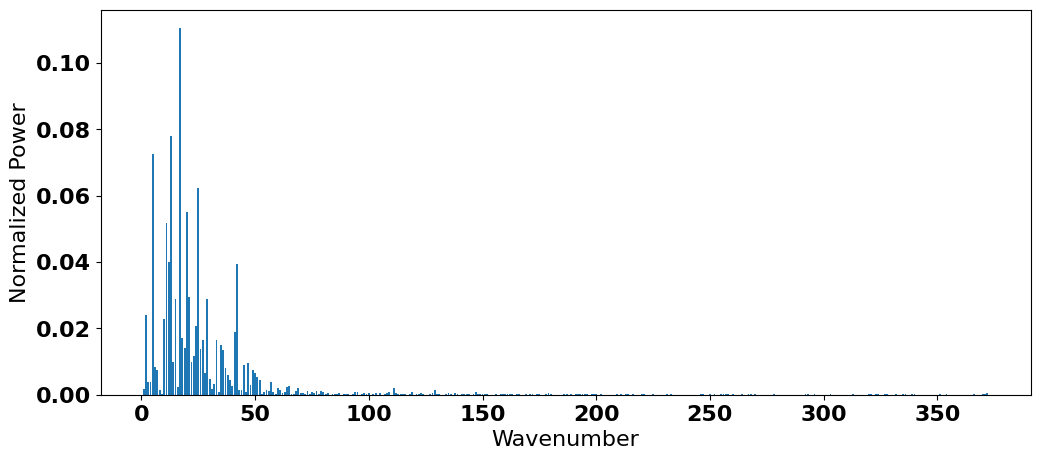

In [217]:
# plot discrete power spectrum
plt.figure(figsize=(12,5))
plt.bar(k_all,ck2/np.sum(ck2))
plt.ylabel('Normalized Power')
plt.xlabel('Wavenumber')

plt.show()

4. Cálculo das primeiras frequências (primeiros 62 números de onda)

In [218]:
# compute frequencies that correspond to first 62 wavenumbers
f = k_all[0:62]/T

# print in terms of years
print(1/(12*f))

[62.         31.         20.66666667 15.5        12.4        10.33333333
  8.85714286  7.75        6.88888889  6.2         5.63636364  5.16666667
  4.76923077  4.42857143  4.13333333  3.875       3.64705882  3.44444444
  3.26315789  3.1         2.95238095  2.81818182  2.69565217  2.58333333
  2.48        2.38461538  2.2962963   2.21428571  2.13793103  2.06666667
  2.          1.9375      1.87878788  1.82352941  1.77142857  1.72222222
  1.67567568  1.63157895  1.58974359  1.55        1.51219512  1.47619048
  1.44186047  1.40909091  1.37777778  1.34782609  1.31914894  1.29166667
  1.26530612  1.24        1.21568627  1.19230769  1.16981132  1.14814815
  1.12727273  1.10714286  1.0877193   1.06896552  1.05084746  1.03333333
  1.01639344  1.        ]


## **4.4. Transformada Rápida de Fourier**

Como foi visto anteriormente, é possivel calcular $C_{k}$
por meio de análise harmônica (ou dependendo da necessidade, os termos $A_{k}$ e $B_{k}$ através da solução analítica para a DFT).

Independente da sua simplicidade, na prática, a DFT não é muito eficiente, pelo qual, as vezes resulta útil o uso de um algoritmo computacional muito mais simples que permita calcular o espectro de potência. Um exemplo disto é o uso do chamado de Fast Fourier Transform (FFT). A FFT é um algoritmo que calcula eficientemente a DFT, portanto a equação é igual à equação da DFT.

### **4.4.1. Transformada Complexa de Fourier**

Até agora, expressamos a Transformada de Fourier usando aritmética real (senos e cossenos); no entanto, é muito mais eficiente escrever a Transformada de Fourier usando aritmética complexa e usando a frequência radial, $\omega$, em vez do número de onda. Isto é:

$$Y\left ( \omega  \right )=\int_{-\infty }^{\infty }y\left ( t \right )e^{-i\omega t}dt$$

onde $Y\left ( \omega  \right )$ é a Transformada de Fourier de uma série temporal $y\left ( t \right )$, $\omega$ é a frequência radial (radianos por unidades de tempo) e $Y\left ( \omega  \right )$ geralmente é um número complexo e $i=\sqrt{-1}$.

Para converter do domínio da frequência de volta para o domínio do tempo, usa-se a Transformada de Fourier inversa:

$$y\left ( t \right )=\frac{1}{2\pi }\int_{-\infty }^{\infty }Y\left ( \omega  \right )e^{i\omega t}d\omega$$

### Exemplo 06. Sinal sintética (ruído branco)
---

1. Criar sinal sintética

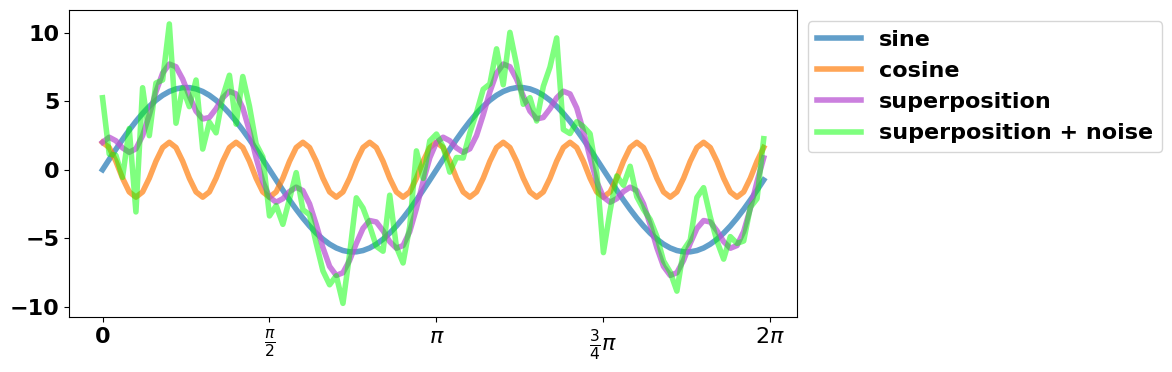

In [219]:
# Create some dummy data:

# define frequencies, amplitudes, and sampling rate and time array:
f1 =  2  # Frequency 1 in Hz
f2 = 10  # Frequency 2 in Hz
A1 = 6   # Amplitude 1
A2 = 2   # Amplitude 2
Fs = 100 # Sampling rate
t  = np.arange(0,1,1/Fs)

# calculate prime signals:
A_sin = A1 * np.sin(2 * np.pi * f1 * t)
A_cos = A2 * np.cos(2 * np.pi * f2 * t)
A_signal = A_sin + A_cos

# add some noise:
np.random.seed(1)
A_Noise = 2
Noise = np.random.randn(len(t)) * A_Noise
A_signal_noisy = A_signal + Noise

# plots:
fig=plt.figure(3, figsize=(12,4))
plt.clf()
plt.plot(t, A_sin, label="sine", lw=4, alpha=0.7)
plt.plot(t, A_cos, label="cosine", lw=4, alpha=0.7)
plt.plot(t, A_signal, lw=4, c="mediumorchid",
         label="superposition", alpha=0.75)
plt.plot(t, A_signal_noisy, lw=4, c="lime",
         label="superposition + noise", alpha=0.5)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.xticks([0, 0.25, 0.5, 0.75, 1],
           ["0", r"$\frac{\pi}{2}$", r"$\pi$",
            r"$\frac{3}{4}\pi$", r"$2\pi$"])
plt.tight_layout()
plt.show()

2. Cálculo da Transformada rápida de Fourier (FFT)

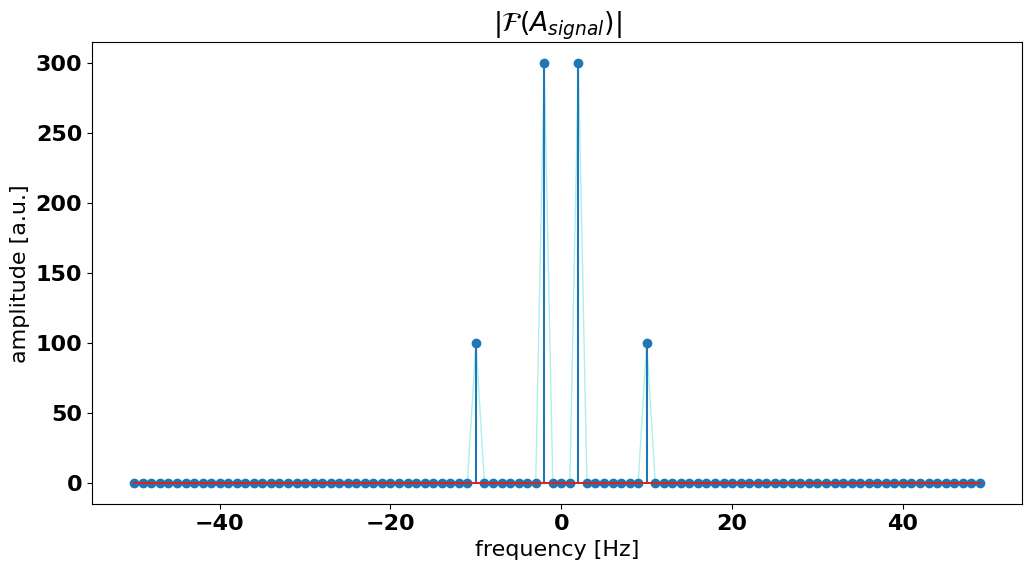

In [220]:
A_signal_fft = scipy.fft.fft(A_signal)
frequencies = scipy.fft.fftfreq(np.size(t), 1/Fs)

fig=plt.figure(2, figsize=(12,6))
plt.clf()
plt.plot(frequencies, np.abs(A_signal_fft), lw=1.0, c='paleturquoise')
plt.stem(frequencies, np.abs(A_signal_fft))
plt.xlabel("frequency [Hz]")
plt.ylabel("amplitude [a.u.]")
plt.title(r"$|\mathcal{F}(A_{signal})|$")
plt.show()

3. Cálculo da FFT (Frequências relativas)

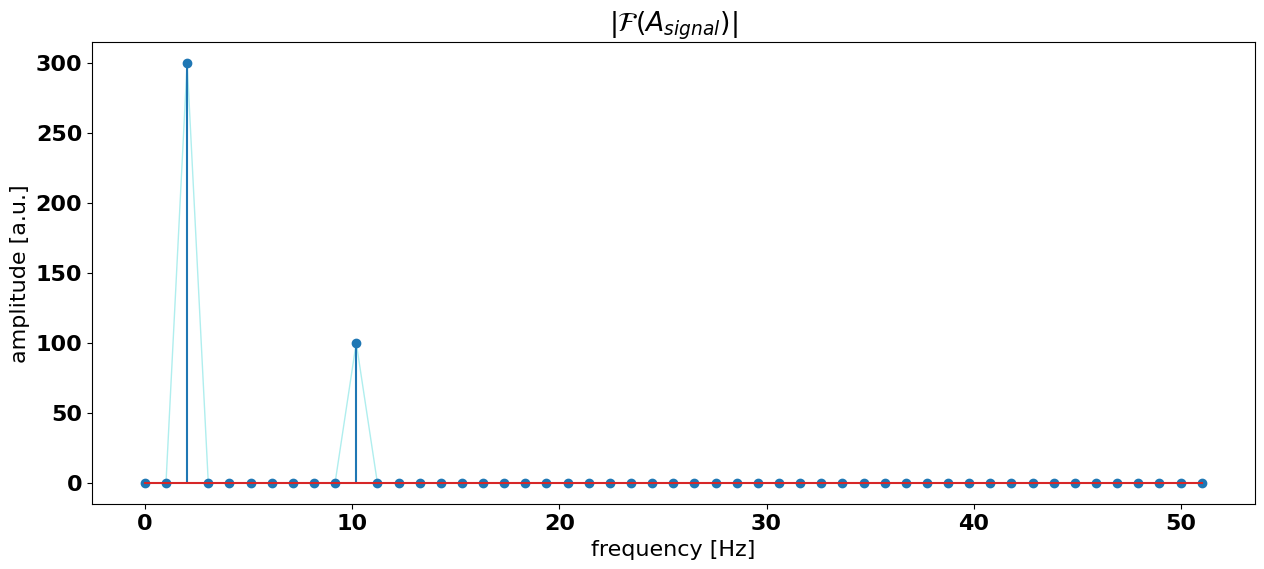

In [221]:
frequency_eval_max = 100
A_signal_rfft = scipy.fft.rfft(A_signal, n=frequency_eval_max)
n = np.shape(A_signal_rfft)[0] # np.size(t)
frequencies_rel = n*Fs/frequency_eval_max * np.linspace(0,1,int(n))

fig=plt.figure(3, figsize=(15,6))
plt.clf()
plt.plot(frequencies_rel, np.abs(A_signal_rfft), lw=1.0, c='paleturquoise')
plt.stem(frequencies_rel, np.abs(A_signal_rfft))
plt.xlabel("frequency [Hz]")
plt.ylabel("amplitude [a.u.]")
plt.title(r"$|\mathcal{F}(A_{signal})|$")
plt.show()

4. Cálculo da Transformada inversa de Fourier

  O sinal transformado de Fourier |$|\mathcal{F}(A_{signal})|$ também pode ser transformado de volta para o domínio espacial, $|\mathcal{F}^{-1}(A_{signal})|$, aplicando a função de transformada rápida de Fourier inversa irfft:

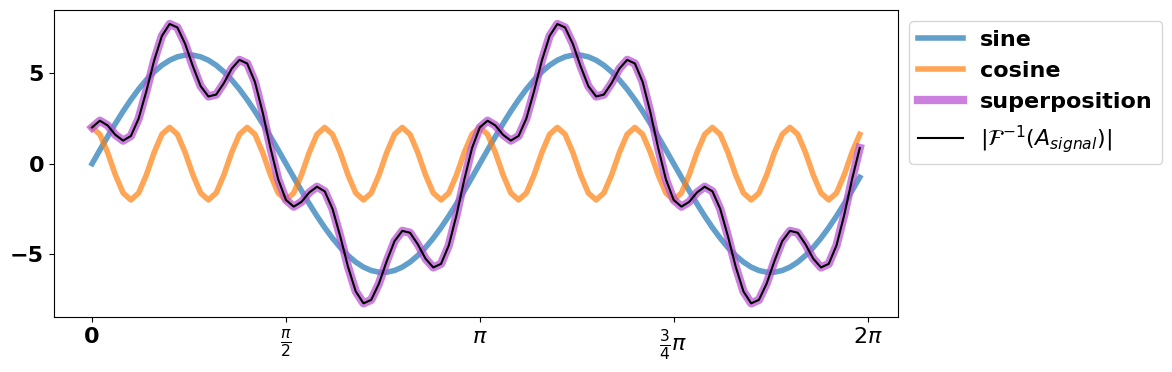

In [222]:
A_signal_irfft = scipy.fft.irfft(A_signal_rfft)

fig=plt.figure(4, figsize=(12,4))
plt.clf()
plt.plot(t, A_sin, label="sine", lw=4, alpha=0.7)
plt.plot(t, A_cos, label="cosine", lw=4, alpha=0.7)
plt.plot(t, A_signal, lw=6, c="mediumorchid",
         label="superposition", alpha=0.75)
plt.plot(t, A_signal_irfft,  c='k',
         label="$|\mathcal{F}^{-1}(A_{signal})|$")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.xticks([0, 0.25, 0.5, 0.75, 1],
           ["0", r"$\frac{\pi}{2}$", r"$\pi$",
            r"$\frac{3}{4}\pi$", r"$2\pi$"])
plt.tight_layout()
plt.show()

5. Cálculo da FFT do sinal com ruido

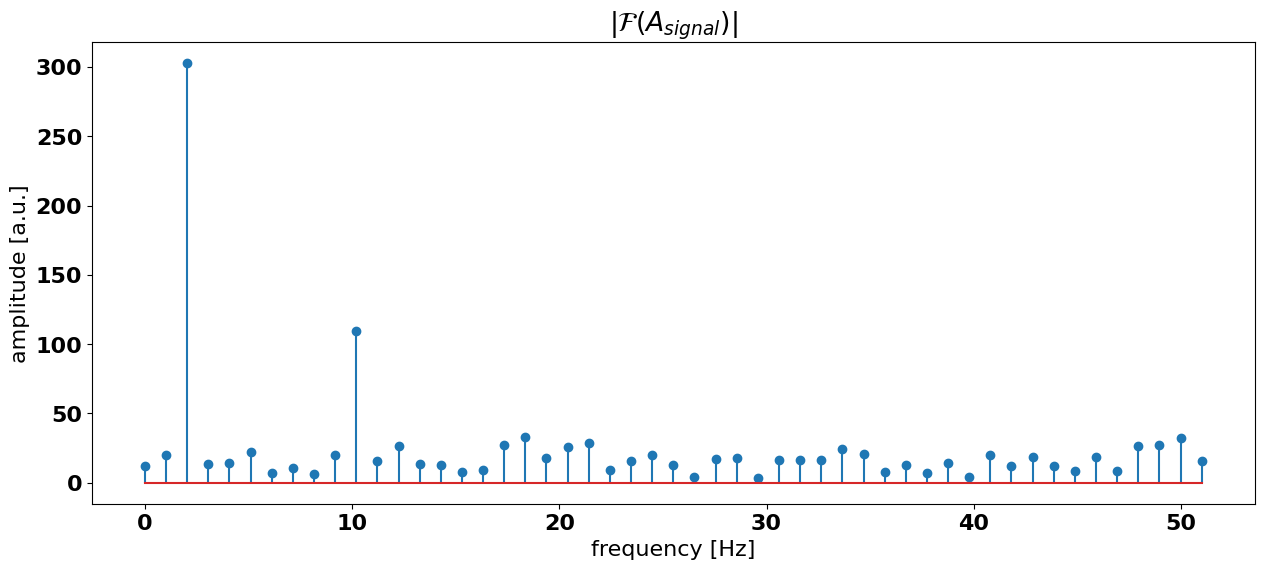

In [223]:
frequency_eval_max = 100
A_signal_rfft = scipy.fft.rfft(A_signal_noisy, n=frequency_eval_max)
n = np.shape(A_signal_rfft)[0] # np.size(t)
frequencies_rel = n*Fs/frequency_eval_max * np.linspace(0,1,int(n))

fig=plt.figure(3, figsize=(15,6))
plt.clf()
plt.stem(frequencies_rel, np.abs(A_signal_rfft))
plt.xlabel("frequency [Hz]")
plt.ylabel("amplitude [a.u.]")
plt.title(r"$|\mathcal{F}(A_{signal})|$")
plt.show()

6. Filtragem de frequências usando frequências obtidas pela Transformada de Fourier

6.1. Criação de função para determinação de valores próximos da frequência principal (criação de janelas)

In [224]:
def find_closest_within_array(array, value):
    """ Finds closest value within an array.

        array: input NumPy array (can also be a list)
        value: value to search for

        array[idx]: found closest value within array
        idx:        index of the found closest value

    """
    numpy_array = np.asarray(array)
    idx = (np.abs(numpy_array-value)).argmin()
    return array[idx], idx

6.2. Determinação do sinal a ser filtrada e reconstrução do sinal no dominio temporal

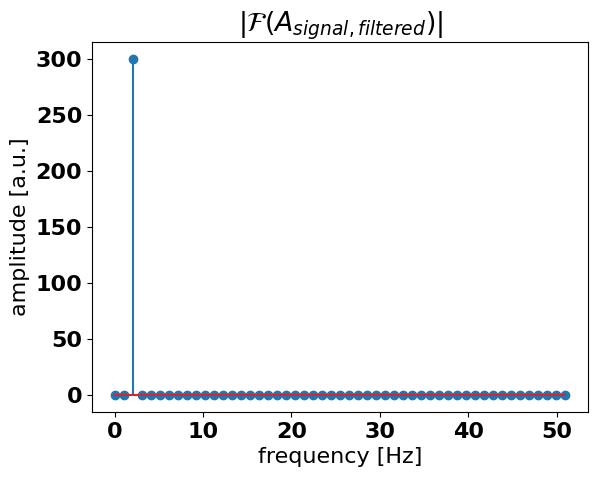

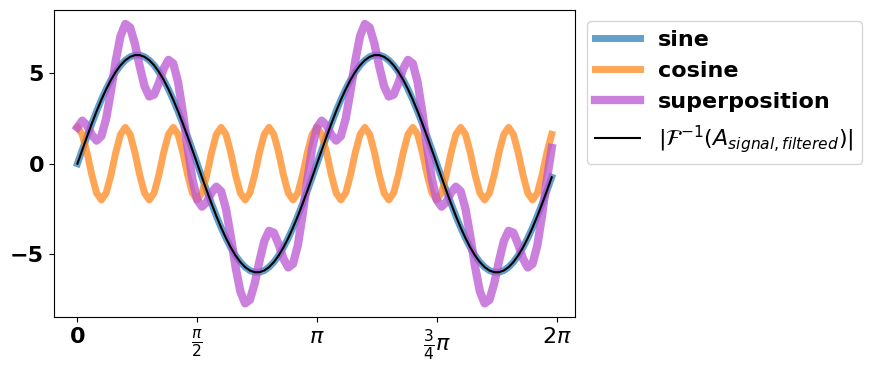

In [225]:
# Solution 2:
frequency_eval_max = 100
A_signal_rfft = scipy.fft.rfft(A_signal, n=frequency_eval_max)
n = np.shape(A_signal_rfft)[0] # np.size(t)
frequencies_rel = n*Fs/frequency_eval_max * np.linspace(0,1,int(n))

filter_frequency = 10
val, idx = find_closest_within_array(frequencies_rel,
                                     filter_frequency)
A_signal_rfft[idx] = 0
A_signal_filtered = scipy.fft.irfft(A_signal_rfft)

fig=plt.figure(5)
plt.clf()
plt.stem(frequencies_rel, np.abs(A_signal_rfft))
plt.xlabel("frequency [Hz]")
plt.ylabel("amplitude [a.u.]")
plt.title(r"$|\mathcal{F}(A_{signal, filtered})|$")

fig=plt.figure(6, figsize=(9,4))
plt.clf()
plt.plot(t, A_sin, label="sine", lw=5, alpha=0.7)
plt.plot(t, A_cos, label="cosine", lw=5, alpha=0.7)
plt.plot(t, A_signal, lw=6, c="mediumorchid",
         label="superposition", alpha=0.75)
plt.plot(t, A_signal_filtered,  c='k',
         label="$|\mathcal{F}^{-1}(A_{signal, filtered})|$")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.xticks([0, 0.25, 0.5, 0.75, 1],
           ["0", r"$\frac{\pi}{2}$", r"$\pi$",
            r"$\frac{3}{4}\pi$", r"$2\pi$"])
plt.tight_layout()
plt.show()

### Exemplo 07. Sinal sintética (espectro de potência)
---
1. Geração do sinal sintética

In [226]:
# Create time variable (decimal days)
n_years = 10
t = np.linspace(0,n_years*365,(n_years*365)*24) # 2 years, sampled hourly, measured in decimal days (no leap years)

# Create fake streamflow with 3 components
Qmeanflow_weight = 15
Qmeanflow = Qmeanflow_weight*np.ones(t.size); # 15 cms baseflow all the time

Qseasonal_weight = 10
Qseasonal = Qseasonal_weight*np.sin(2*np.pi*(t-60)/365); # annual repeat cycle, peak in May

Qdaily_weight = 1
Qdaily = Qdaily_weight*np.sin(2*np.pi*(t-6/24)); # diurnal cycle, peak at noon

2. Geração de sinais de ruído

Maior informação: [cores de ruído](https://pt.wikipedia.org/wiki/Cores_de_ru%C3%ADdo)

2.1. Função para criação do ruido vermelho

In [227]:
def rednoise(r,var,N):
    '''
    # r is the lag-1 correlation coefficient
    # var is the variance in the original white noise spectrum
    # N is the length of the series.
    '''
    xwhite = np.sqrt(var)*np.random.normal(size=N) # create some white noise
    xred = xwhite # start off with white
    for ii in range(2,N): # add more red, mix, and repeat
        xred[ii] = r*xred[ii-1] + np.sqrt(1-r**2)*xwhite[ii]

    return xred

2.2. Geração e implementação do ruído branco e vermelho

In [228]:
# red noise (lower frequency)
sigmaR = 3 #set the variance of the red noise
r = 0.99 # This is the weighting of the lag-1 regression model (how much does each step
# depend on the step prior) -- try varying it from 0.5 to 0.99
var = 1 #This is the variance of the white noise in the lag-1 regression model -- try varying it as well
rednoise = sigmaR*rednoise(r,var,t.size) #see rednoise function above

# white noise (all frequencies)
sigmaW = 0.2 #set the variance of the white noise
whitenoise = sigmaW*np.random.normal(size=t.size) # make some white noise

3. Criação do sinal final (sinal + ruído)

In [229]:
Qsum = Qmeanflow + Qseasonal + Qdaily + whitenoise + rednoise # simulate data by summing all these components together

4. Plotagem de resultados

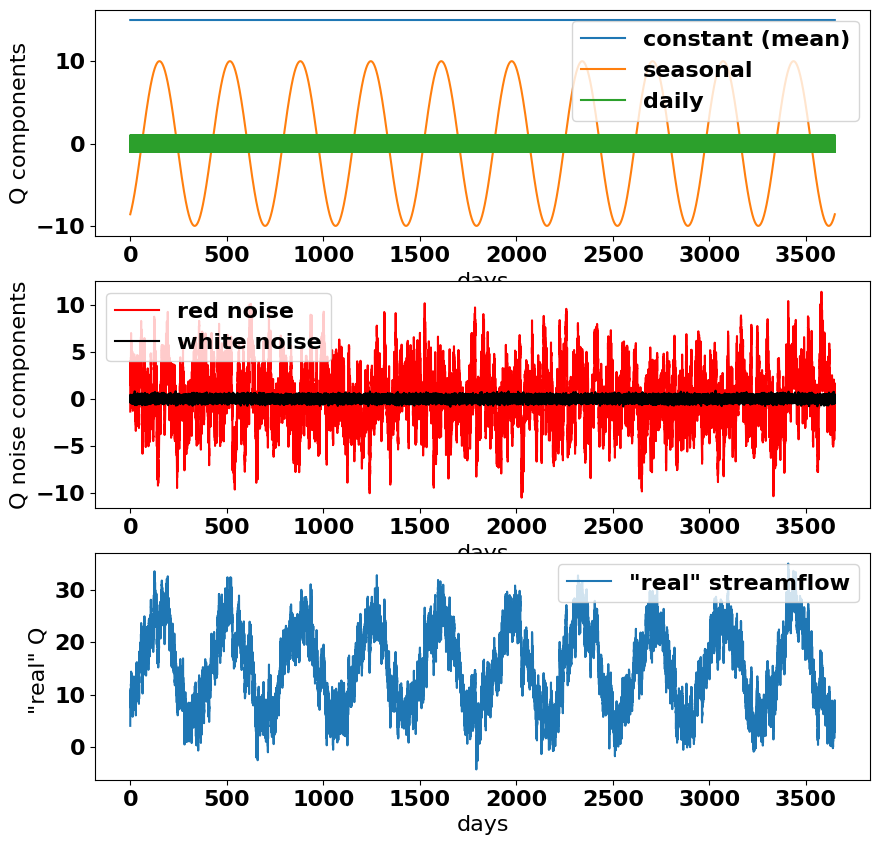

In [230]:
f, ax = plt.subplots(3,1,figsize=(10,10))

ax[0].plot(t,Qmeanflow,'-',label='constant (mean)')
ax[0].plot(t,Qseasonal,'-',label='seasonal')
ax[0].plot(t,Qdaily,'-',label='daily')
ax[0].legend(loc='upper right')
ax[0].set_ylabel('Q components')
ax[0].set_xlabel('days')

ax[1].plot(t,rednoise,'r',label='red noise')
ax[1].plot(t,whitenoise,'k',label='white noise')
ax[1].legend(loc='upper left')
ax[1].set_ylabel('Q noise components')
ax[1].set_xlabel('days')


ax[2].plot(t,Qsum, label='"real" streamflow')
ax[2].legend(loc='upper right')
ax[2].set_ylabel('"real" Q ')
ax[2].set_xlabel('days');

5. Cálculo da FFT

In [239]:
N = len(Qsum) # make sure our dataset is even

# fft of Qsum
X = np.fft.fft(Qsum)
X.shape

sample_spacing = 1/24 # our sample spacing in time, in units of days (see how we defined t for our timeseries above)

# returns frequency in cycles per unit of the sample spacing
freqs = np.fft.fftfreq(N, sample_spacing) # compute frequencies giving the number of timesteps (N) and the spacing between each timesetep

# only look at positive frequencies
X = X[freqs>0]
freqs = freqs[freqs>0]

6. Plotagem de resultados

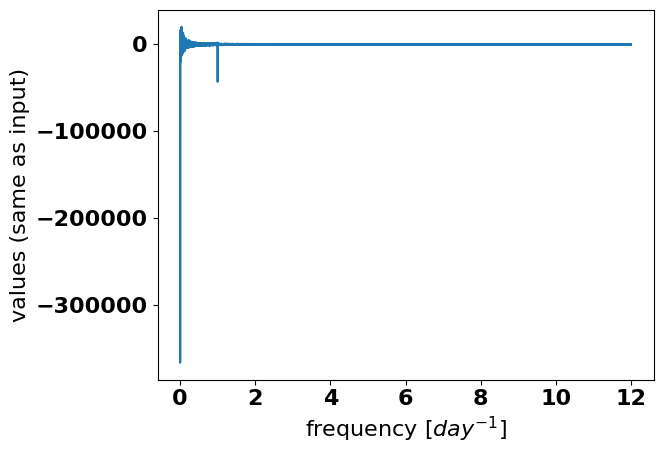

In [240]:
plt.plot(freqs, X)
plt.xlabel('frequency [$day^{-1}$]')
plt.ylabel('values (same as input)');

6. Plotagem de frequências por harmônico

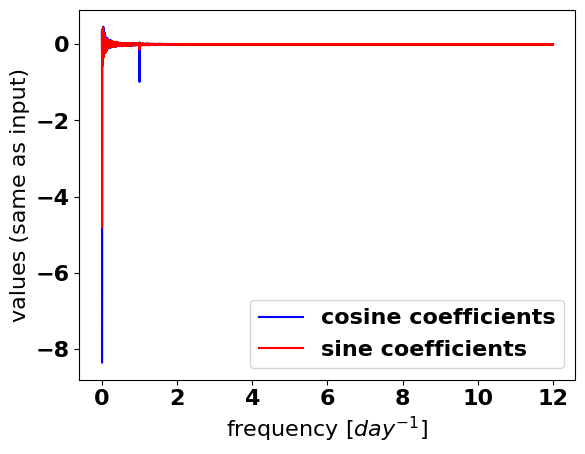

In [236]:
plt.plot(freqs,X.real/ (N/2),c='b',label='cosine coefficients')
plt.plot(freqs,X.imag/ (N/2),c='r',label='sine coefficients')
plt.xlabel('frequency [$day^{-1}$]')
plt.ylabel('values (same as input)')
plt.legend();

7. Criação do PSD (Power Spectral Density)

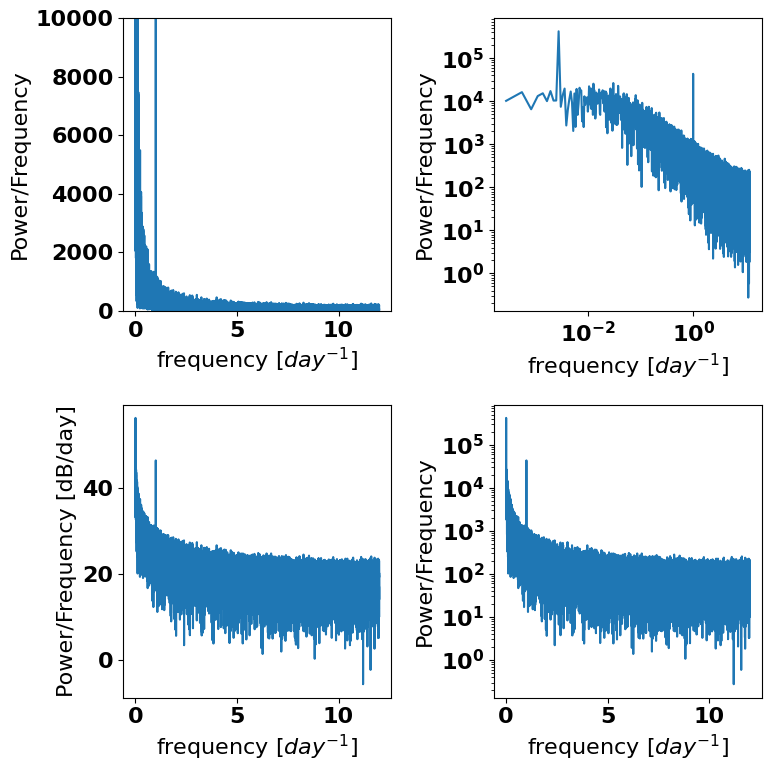

In [241]:
p = np.abs(X) # take absolute value to "fold over" power for PSD

f, ax = plt.subplots(2,2,figsize=(8,8))
ax[0,0].plot(freqs,p)
ax[0,0].set_ylim((0,10000)) # zoom in on the y axis
ax[0,0].set_ylabel('Power/Frequency')
ax[0,0].set_xlabel('frequency [$day^{-1}$]')

ax[0,1].plot(freqs,p)
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].set_ylabel('Power/Frequency')
ax[0,1].set_xlabel('frequency [$day^{-1}$]')


ax[1,0].plot(freqs,10*np.log10(p)) # power in decibels
ax[1,0].set_ylabel('Power/Frequency [dB/day]')
ax[1,0].set_xlabel('frequency [$day^{-1}$]')

ax[1,1].plot(freqs,p)
ax[1,1].set_yscale('log')
ax[1,1].set_ylabel('Power/Frequency')
ax[1,1].set_xlabel('frequency [$day^{-1}$]')

plt.tight_layout()

8. Redução de ruido (filtragem) usando multiplas PSD

8.1. Geração da janela de análise

In [244]:
n_window = 10 # Divide our full timeseries into multiple "windows" or chunks (make sure we're getting a whole number for window_size)
window_size = N/n_window
print(f'reshaping into {window_size} by {n_window}')
Qsum_reshaped = np.reshape(Qsum,(int(window_size),int(n_window)),order='F')

reshaping into 8760.0 by 10


8.2. Criação de função para análise por janelas

In [245]:
def power_spectral_density(x, sample_spacing):
    # get length of our dataset
    N = len(x)

    # compute fft
    X = np.fft.fft(x)

    # returns frequency in cycles per unit of the sample spacing
    freqs = np.fft.fftfreq(N, sample_spacing) # compute frequencies giving the number of timesteps (N) and the spacing between each timesetep

    # only look at positive frequencies
    X = X[freqs>0]
    freqs = freqs[freqs>0]

    p = np.abs(X) # take absolute value to "fold over" power for PSD

    return freqs, p

8.3. Rodar a função principal

In [246]:
# create empty array to put our results in
p_window = np.zeros((int(window_size/2)-1, int(n_window)))

# Peform fft on each of the subsets of the total timeseries
for m in range(int(n_window)):
    f_window , p_window[:,m] = power_spectral_density(Qsum_reshaped[:,m],sample_spacing);

# take the mean of the power across all windows
p_mean = np.mean(p_window,axis=1)

8.4. Apresentação de resultados

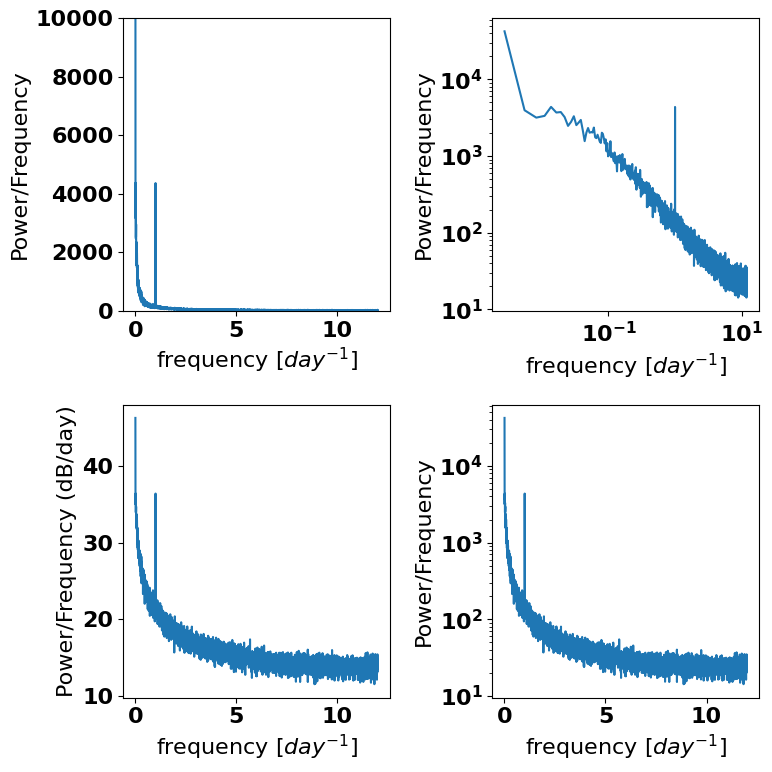

In [247]:
f, ax = plt.subplots(2,2,figsize=(8,8))
ax[0,0].plot(f_window,p_mean)
ax[0,0].set_ylim((0,10000)) # zoom in on the y axis
ax[0,0].set_ylabel('Power/Frequency')
ax[0,0].set_xlabel('frequency [$day^{-1}$]')

ax[0,1].plot(f_window,p_mean)
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].set_ylabel('Power/Frequency')
ax[0,1].set_xlabel('frequency [$day^{-1}$]')


ax[1,0].plot(f_window,10*np.log10(p_mean)) # power in decibels
ax[1,0].set_ylabel('Power/Frequency (dB/day)')
ax[1,0].set_xlabel('frequency [$day^{-1}$]')

ax[1,1].plot(f_window,p_mean)
ax[1,1].set_yscale('log')
ax[1,1].set_ylabel('Power/Frequency')
ax[1,1].set_xlabel('frequency [$day^{-1}$]')

plt.tight_layout()